In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import noror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
trajectories = noror.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')
derivs = noror.utils.load_trajectories(filename='../derivs_n_kmax=200.npz')


ind = 1

trajectories = trajectories[::ind]
derivs = derivs[::ind]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_trajectories = trajectories[:cutoff]
train_derivs = derivs[:cutoff]

test_trajectories = trajectories[cutoff:]
test_derivs = derivs[cutoff:]


1000 loaded with n_kmax = 200


In [189]:
dim_reducer = noror.dim_reducers.SVD()
scaler = noror.scalers.standardize_scaler(1.0)
transformer = noror.transformers.ELM_features(ELM_nodes=400)
optimizer = noror.optimizers.ridge(alpha=10.**-3)

model = noror.noror(train_trajectories, train_derivs, rdim=15, VAR_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    VAR_transformer=transformer)

model.train()

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  15
VAR_l:  2
train shape:  (360000, 431)
target shape:  (360000, 200)
weights shape:  (431, 200)


In [190]:
ind = 0

test_trajectory = test_trajectories[ind]
truth = test_derivs[ind]

pred = model.predict(test_trajectory)

print( model.get_error(test_trajectory,truth,pred,norm='NF') ) 
print( model.get_error(test_trajectory,truth,norm='NF') ) 
print( model.get_error(truth=truth, pred=pred, norm='max') ) 

2.98957774485093e-05
2.98957774485093e-05
0.00044970235496265715


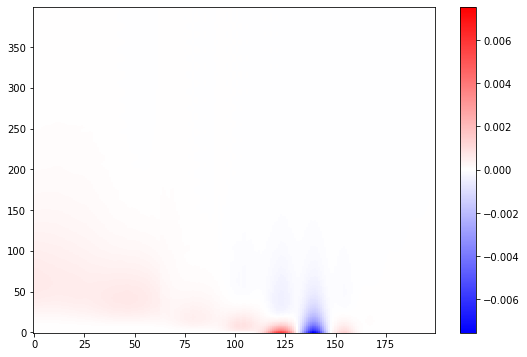

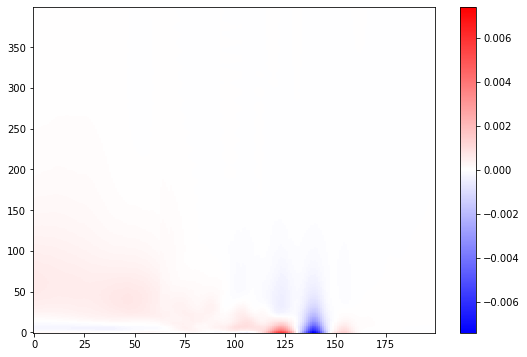

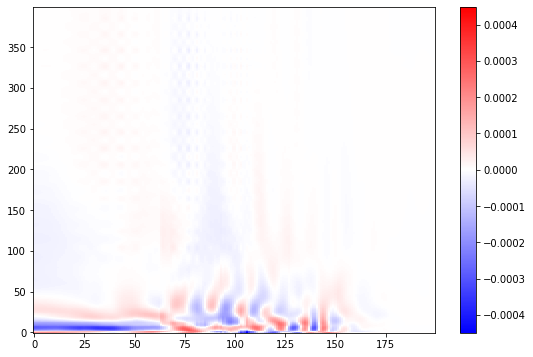

In [191]:
import matplotlib.colors as colors

plt.imshow(truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

plt.imshow(pred, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


plt.imshow(pred-truth, aspect='auto', interpolation='none',origin='lower',cmap='bwr', norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


2.448662550297509e-05


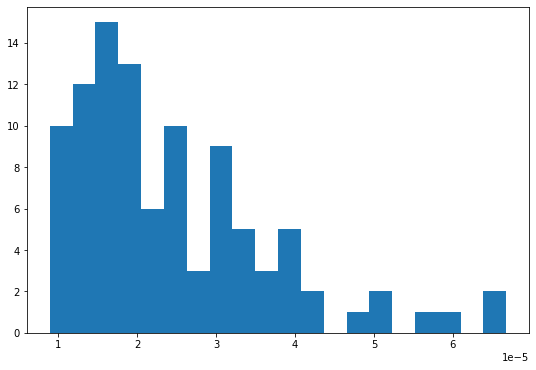

In [178]:
mean, scrs = model.score_multiple_trajectories(test_trajectories,test_derivs, norm='NF')

print(mean)

plt.hist(scrs, bins=20)
plt.show()

In [179]:
scores = noror.utils.get_KFold_CV_scores(model, trajectories, derivs, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs={})

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  2.404982533885039e-05 +- 1.430580333563458e-05
max error:  0.0005388582971550485 +- 0.00045301096738557513


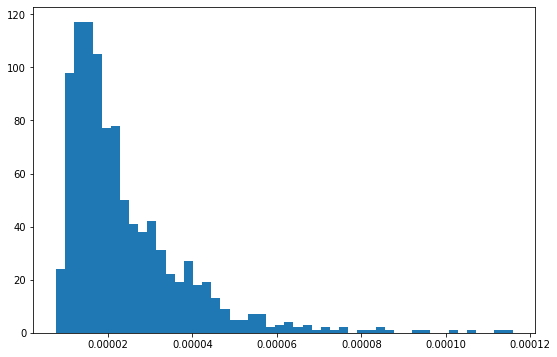

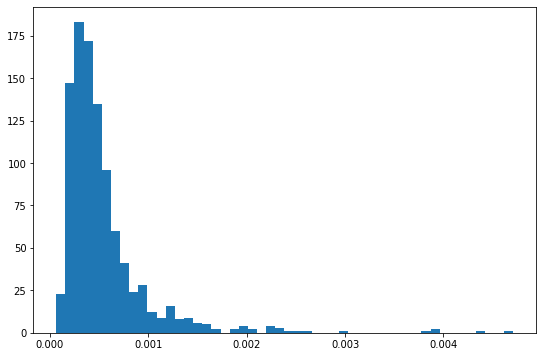

In [180]:
plt.hist(scores[0],bins=50)
plt.show()

plt.hist(scores[1],bins=50)
plt.show()

In [181]:
class AI_integrator:
    
    def __init__(self, model, dt=1., dt_out=1.):
        self.model = model
        self.dt = dt
        self.dt_out = dt_out
        
        self.targets = 'AR'
    
    def load_data(self, **kwargs):
        self.model.load_data(**kwargs)
    
    def train(self, **kwargs):
        self.model.train(**kwargs)
        
    def integrate(self, init, n_steps, dt=None, dt_out=None):
        
        if dt is None:
            dt = self.dt
        if dt_out is None:
            dt_out = self.dt_out
        
        sol = np.zeros((n_steps,init.shape[1]))
        
        sol[:init.shape[0]] = init
        
        state = sol[0]
        
        j_out = int(dt_out/dt)
        j_max = pred.shape[0]*j_out
        
        
        for j in range(1,pred.shape[0]*j_out):
            state = state + dt*self.model.predict(state)
            
            if j%j_out == 0:
                sol[j//j_out] = state
                
        return sol

    
    def get_error(self, truth, pred=None, norm='NF'):
        
        if pred is None:
            pred = self.integrate(truth, truth.shape[0])
        
        assert pred.shape == truth.shape
        
        err = -1.
        if norm =='NF': #normalized Frobenius norm
            err = np.sqrt( np.mean( np.square(truth-pred) ) )
        elif norm == 'fro': #Frobenius norm
            err = np.linalg.norm(truth-pred, ord='fro')
        elif norm =='max': #absolute max norm
            err = np.abs(truth-pred).max()
        else:
            print('unknown norm')
        
        return err
    
    def score_multiple_trajectories(self,trajectories,targets=None,**kwargs):
        scores = []
        for k in range(len(trajectories)):
            scores.append(self.get_error(trajectories[k],**kwargs))
        
        mean = np.mean(scores)
        return mean, scores
    
    
integrator = AI_integrator(model, dt=1., dt_out=5.)

NF error: 0.0055290393667297546
max error: 0.017776862758378253


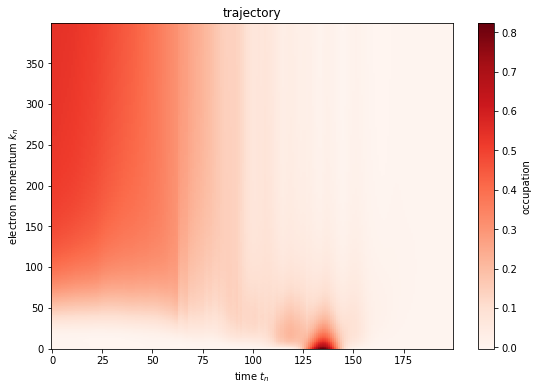

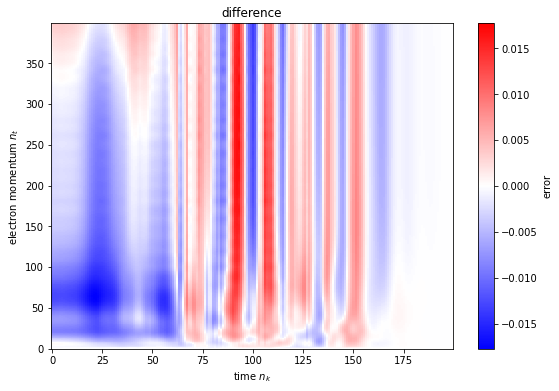

In [182]:
test_trajectory = test_trajectories[1]


pred = integrator.integrate(test_trajectory,test_trajectory.shape[0])


print('NF error:', integrator.get_error(test_trajectory,pred, norm='NF'))
print('max error:', integrator.get_error(test_trajectory,pred, norm='max'))


noror.utils.plot_trajectory(pred)

noror.utils.plot_difference(truth=test_trajectory,test=pred)


In [183]:
mean,scrs = integrator.score_multiple_trajectories(test_trajectories,norm='NF')

0.005164895755898366
100


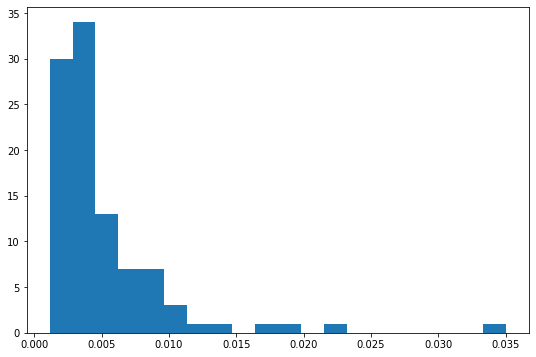

In [184]:
print(mean)
print(len(scrs))

plt.hist(scrs, bins=20)
plt.show()

In [185]:
scores = noror.utils.get_KFold_CV_scores(integrator, trajectories, derivs, folds=10, seed=817,
                                          norms=['NF','max'],
                                          train_kwargs={})

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.0057356496369049366 +- 0.006127509260112865
max error:  0.022401492096286234 +- 0.030281901091981547


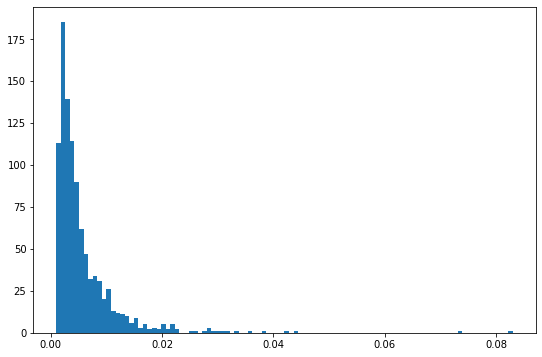

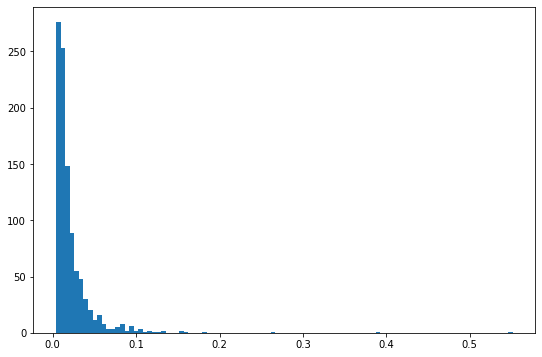

In [186]:
plt.hist(scores[0],bins=100)
plt.show()

plt.hist(scores[1],bins=100)
plt.show()